# Capstone Project

In [1]:
!pip install bs4
!pip install geocoder
!pip install geopy
!pip install folium
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import geocoder 
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

     |████████████████████████████████| 122kB 42.2MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 102kB 21.3MB/s ta 0:00:01
     |████████████████████████████████| 122kB 23.6MB/s eta 0:00:01


In [2]:
CLIENT_ID = 'VKSF23CDMY4ZREOJQQFJQECKY3GLNWPR0JPWSHZ522PLATDD' # your Foursquare ID
CLIENT_SECRET = 'FRFKQBVUJNZTROCWNKCQHFAUBBKETDULASFX1S11S1GTZ0LV' # your Foursquare Secret
ACCESS_TOKEN = '5YEX00B2MU2SUMNAKMCVWUYKO1KYZRK4DGYKJ4DU15ZBFR3M' # your FourSquare Access Token
VERSION = '20210811'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VKSF23CDMY4ZREOJQQFJQECKY3GLNWPR0JPWSHZ522PLATDD
CLIENT_SECRET:FRFKQBVUJNZTROCWNKCQHFAUBBKETDULASFX1S11S1GTZ0LV


In [3]:
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Chicago, USA'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)




## Preparation of the data

In [4]:
url = "https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago"

# get the contents of the webpage in text format and store in a variable called data
data  = requests.get(url).text

#Parse Data Using BeautifulSoup
soup = BeautifulSoup(data,"html5lib")

#find table for neighbourhoods first on website
table = soup.find_all('table')[0]



In [5]:
chicago_nh_ca = pd.read_html(str(table), flavor='bs4')[0]

chicago_nh_ca

,Neighborhood,Community area
0,Albany Park,Albany Park
1,Altgeld Gardens,Riverdale
2,Andersonville,Edgewater
3,Arcadia Terrace,West Ridge
4,Archer Heights,Archer Heights
...,...,...
242,Wildwood,Forest Glen
243,Woodlawn,Woodlawn
244,Wrightwood,Ashburn
245,Wrightwood Neighbors,Lincoln Park


In [8]:
chicago_nh =chicago_nh_ca["Neighborhood"]
chicago_nh


0               Albany Park
1           Altgeld Gardens
2             Andersonville
3           Arcadia Terrace
4            Archer Heights
               ...         
242                Wildwood
243                Woodlawn
244              Wrightwood
245    Wrightwood Neighbors
246            Wrigleyville
Name: Neighborhood, Length: 247, dtype: object

In [7]:
coords = [get_latlng(neighborhood) for neighborhood in chicago_nh.tolist()]
print("- finished scraping coordinates for all neighborhoods")
neighborhoods = pd.concat([chicago_nh, pd.DataFrame(columns=["Latitude", "Longitude"], data=coords)], axis=1)
chicago_venues = getNearbyVenues(names=chicago_nh,
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )
print("- finished scraping top 100 venues in each neighborhood")

- finished scraping coordinates for all neighborhoods
Albany Park
Altgeld Gardens
Andersonville
Arcadia Terrace
Archer Heights
Armour Square
Ashburn
Ashburn Estates
Auburn Gresham
Avalon Park
Avondale
Avondale Gardens
Back of the Yards
Belmont Central
Belmont Gardens
Belmont Heights
Belmont Terrace
Beverly
Beverly View
Beverly Woods
Big Oaks
Northalsted "Boystown"
Bowmanville
Brainerd
Brickyard
Bridgeport
Brighton Park
Bronzeville
Bucktown
Budlong Woods
Buena Park
Burnside
Cabrini–Green
Calumet Heights
Canaryville
Central Station
Chatham
Chicago Lawn
Chinatown
Chrysler Village
Clarendon Park
Clearing East
Clearing West
Cottage Grove Heights
Cragin
Crestline
Dearborn Homes
Dearborn Park
Douglas Park
Dunning
East Beverly
East Chatham
East Garfield Park
East Hyde Park
East Pilsen
East Side
East Village
Eden Green
Edgebrook
Edgewater
Edgewater Beach
Edgewater Glen
Edison Park
Englewood
Fernwood
Fifth City
Ford City
Forest Glen
Fuller Park
Fulton River District
Gage Park
Galewood
The Gap
Ga

In [10]:
chicago_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Albany Park,41.96829,-87.72338,Lawrence Fish Market,41.968280,-87.726250,Seafood Restaurant
1,Albany Park,41.96829,-87.72338,Chicago Kalbi Korean BBQ,41.968314,-87.722771,Korean Restaurant
2,Albany Park,41.96829,-87.72338,Starbucks,41.968911,-87.728817,Coffee Shop
3,Albany Park,41.96829,-87.72338,El Gallo Bravo #6,41.968324,-87.721338,Mexican Restaurant
4,Albany Park,41.96829,-87.72338,Rojo Gusano,41.968425,-87.724549,Taco Place
...,...,...,...,...,...,...,...
6340,Wrigleyville,41.94725,-87.65320,CTA Bus Stop 1825,41.944617,-87.654612,Bus Station
6341,Wrigleyville,41.94725,-87.65320,Chase ATM,41.944031,-87.653679,ATM
6342,Wrigleyville,41.94725,-87.65320,CTA Bus Stop 5361,41.947426,-87.647445,Bus Station
6343,Wrigleyville,41.94725,-87.65320,CTA #152 Bus Stop at Addison & Racine,41.947506,-87.658993,Bus Station


## Exploring the data

<function matplotlib.pyplot.show(close=None, block=None)>

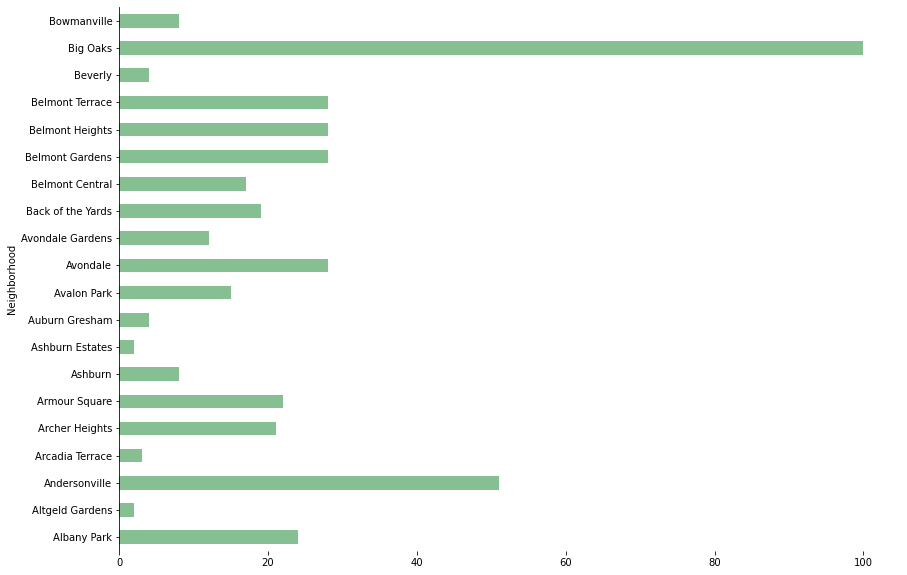

In [11]:

venues_counts = chicago_venues[["Neighborhood", "Venue Category"]].groupby("Neighborhood", as_index=False).count()[:20]
ax = venues_counts.plot(figsize=(14, 10), x="Neighborhood", kind="barh", color='#86bf91')
#ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_legend().remove()
#ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="off", left="off", right="off", labelleft="on")

plt.show

In [12]:
venues_counts = chicago_venues[["Neighborhood", "Venue Category"]].groupby("Neighborhood", as_index=False).count()[:20]
venues_counts

,Neighborhood,Venue Category
0,Albany Park,24
1,Altgeld Gardens,2
2,Andersonville,51
3,Arcadia Terrace,3
4,Archer Heights,21
5,Armour Square,22
6,Ashburn,8
7,Ashburn Estates,2
8,Auburn Gresham,4
9,Avalon Park,15


In [13]:
top_venue_counts_sorted =venues_counts.sort_values("Venue Category")
top_venue_counts_sorted 

,Neighborhood,Venue Category
1,Altgeld Gardens,2
7,Ashburn Estates,2
3,Arcadia Terrace,3
17,Beverly,4
8,Auburn Gresham,4
19,Bowmanville,8
6,Ashburn,8
11,Avondale Gardens,12
9,Avalon Park,15
13,Belmont Central,17


In [38]:
nieghborhood_name_list = top_venue_counts_sorted["Neighborhood"].tolist()


<function matplotlib.pyplot.show(close=None, block=None)>

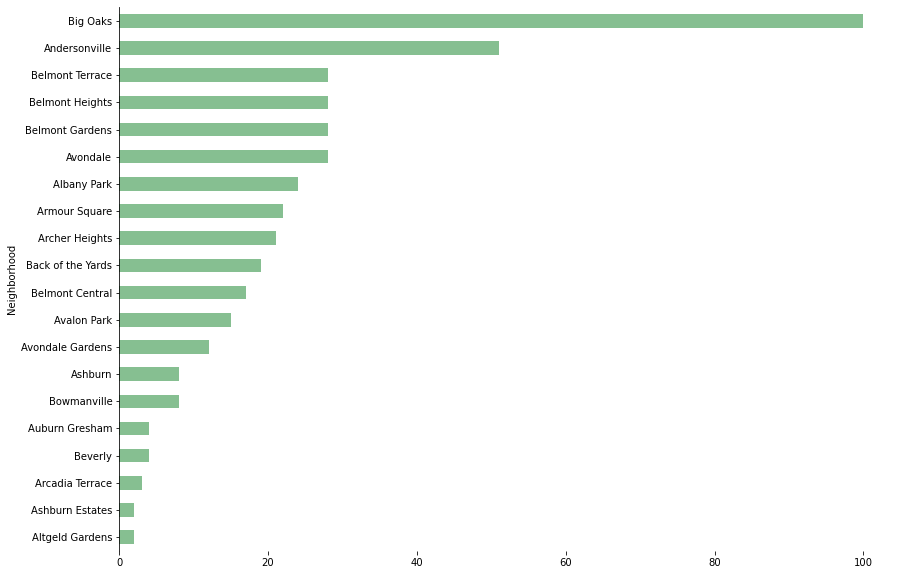

In [14]:
# Top twenty venues in terms of categories

ax = top_venue_counts_sorted.plot(figsize=(14, 10), x="Neighborhood", kind="barh", color='#86bf91')
#ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_legend().remove()
#ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="off", left="off", right="off", labelleft="on")

plt.show

In [52]:
# Apply one-hot encoding to Venue Category
ohe = OneHotEncoder(sparse=False, dtype=int)

chicago_oht = pd.concat((chicago_venues, pd.DataFrame(ohe.fit_transform(chicago_venues[["Venue Category"]]),
                           columns=ohe.categories_[0])),
          axis=1)
chicago_oht

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,ATM,Accessories Store,Afghan Restaurant,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo Exhibit
0,Albany Park,41.96829,-87.72338,Lawrence Fish Market,41.968280,-87.726250,Seafood Restaurant,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Albany Park,41.96829,-87.72338,Chicago Kalbi Korean BBQ,41.968314,-87.722771,Korean Restaurant,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Albany Park,41.96829,-87.72338,Starbucks,41.968911,-87.728817,Coffee Shop,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Albany Park,41.96829,-87.72338,El Gallo Bravo #6,41.968324,-87.721338,Mexican Restaurant,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Albany Park,41.96829,-87.72338,Rojo Gusano,41.968425,-87.724549,Taco Place,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6340,Wrigleyville,41.94725,-87.65320,CTA Bus Stop 1825,41.944617,-87.654612,Bus Station,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6341,Wrigleyville,41.94725,-87.65320,Chase ATM,41.944031,-87.653679,ATM,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6342,Wrigleyville,41.94725,-87.65320,CTA Bus Stop 5361,41.947426,-87.647445,Bus Station,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6343,Wrigleyville,41.94725,-87.65320,CTA #152 Bus Stop at Addison & Racine,41.947506,-87.658993,Bus Station,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
chicago_grouped = chicago_oht.groupby('Neighborhood').mean().reset_index()

# Generate the top 10 most common venue categories in each neighborhood 
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

#create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#Define the function that returns the most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[5:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
        
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chicago_grouped['Neighborhood']

for ind in np.arange(chicago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted = neighborhoods_venues_sorted
neighborhoods_venues_sortedt20 =neighborhoods_venues_sorted[ neighborhoods_venues_sorted["Neighborhood"].isin(nieghborhood_name_list)]
neighborhoods_venues_sortedt20 = neighborhoods_venues_sortedt20.set_index("Neighborhood")
neighborhoods_venues_sortedt20.shape
chicago_groupedt20 = chicago_grouped[ chicago_grouped["Neighborhood"].isin(nieghborhood_name_list)]
chicago_groupedt20

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo Exhibit
0,Albany Park,41.968290,-87.723380,41.968333,-87.726003,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,Altgeld Gardens,41.654480,-87.602250,41.655067,-87.598353,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,Andersonville,41.980460,-87.668340,41.979014,-87.668496,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.019608,0.0,0.019608,0.000000,0.000000,0.0,0.0,0.0,0.0
3,Arcadia Terrace,28.560800,-81.298950,28.563096,-81.302490,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,Archer Heights,41.811540,-87.725560,41.811803,-87.723771,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.047619,0.0,0.0,0.0,0.0
5,Armour Square,41.834580,-87.631890,41.835689,-87.632406,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
6,Ashburn,41.747850,-87.709950,41.749768,-87.709394,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
7,Ashburn Estates,41.941680,-88.198807,41.938936,-88.195809,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
8,Auburn Gresham,41.743190,-87.655040,41.742788,-87.658380,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
9,Avalon Park,41.745070,-87.588160,41.745632,-87.586383,0.066667,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [65]:
colnames = neighborhoods_venues_sortedt20.columns.to_list()
chicago_groupedt20 = chicago_groupedt20.set_index("Neighborhood")
chi_neighborhood_names = chicago_groupedt20.index.to_list()
chi_neighborhood_names

['Albany Park',
 'Altgeld Gardens',
 'Andersonville',
 'Arcadia Terrace',
 'Archer Heights',
 'Armour Square',
 'Ashburn',
 'Ashburn Estates',
 'Auburn Gresham',
 'Avalon Park',
 'Avondale',
 'Avondale Gardens',
 'Back of the Yards',
 'Belmont Central',
 'Belmont Gardens',
 'Belmont Heights',
 'Belmont Terrace',
 'Beverly',
 'Big Oaks',
 'Bowmanville']

In [68]:
# Preparing the dataframe for the heatmap
heatmap_dict = {}
for i in range(len(colnames)):
    for j in range(len(chi_neighborhood_names)+1):
        try:
            heatmap_dict[colnames[i]].append(
                chicago_groupedt20.loc[chi_neighborhood_names[j-1], neighborhoods_venues_sortedt20.loc[chi_neighborhood_names[j-1], colnames[i]]])
        except:
            heatmap_dict[colnames[i]] = []
heatmap_df = pd.DataFrame(index=chi_neighborhood_names, data=heatmap_dict)            


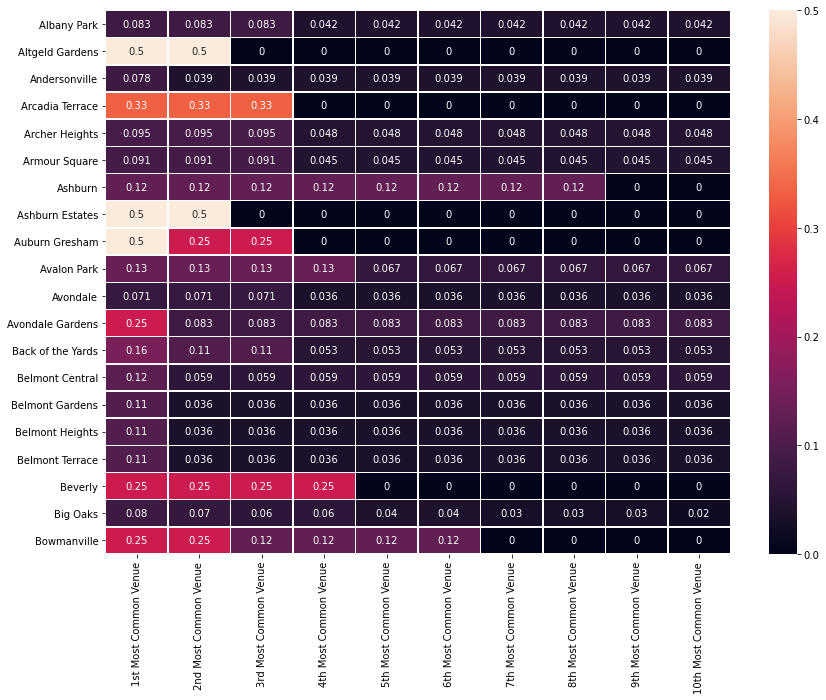

In [67]:
#Plotting the heatmap visual

plt.figure(figsize=(14, 10))
ax = sns.heatmap(heatmap_df, linewidths=.5, annot=True)
# Loop over data dimensions and create text annotations.
#for i in range(len(neighborhood_names)):
#    for j in range(len(colnames)):
#        text = ax.text(j, i, labels[i, j][:5],
 #                      ha="center", va="center", color="w")

In [69]:
neighborhoods_venues_sortedt20.reset_index(inplace=True)
chicago_groupedt20.reset_index(inplace=True)

## Clustering

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  return_n_iter=True)


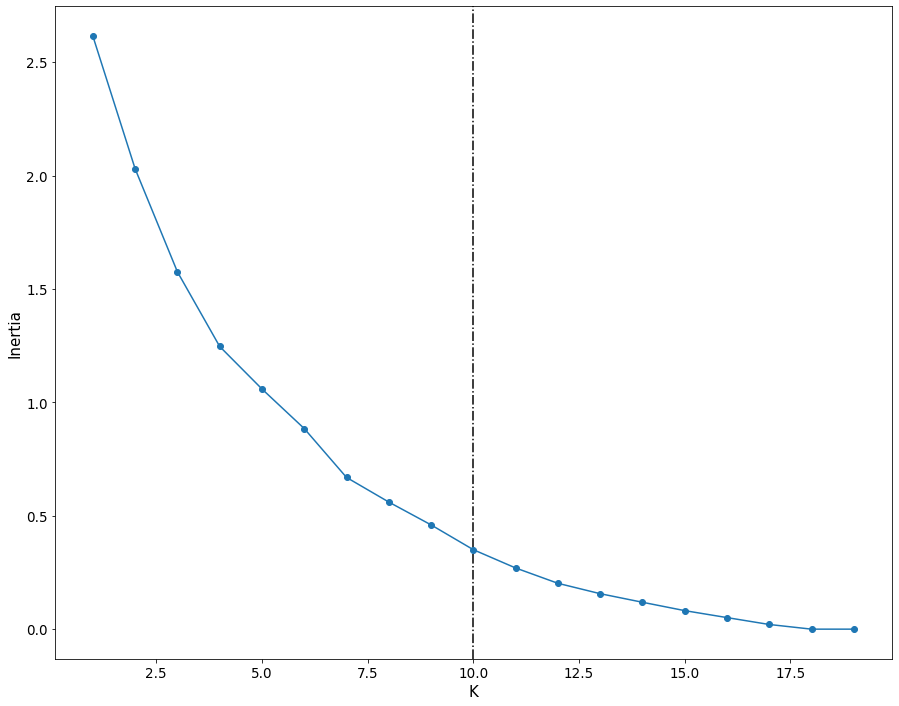

In [77]:
# Cluster neighborhood 
chicago_clustering = chicago_groupedt20.drop(columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue Latitude', 'Venue Longitude'])

# Use elbow methods to decide k
kmeans = list()
for k in range(1,20):
    kmeans.append(KMeans(n_clusters=k, random_state=0, ).fit(chicago_clustering))
    
# Defining the function to plot elbow plot

def plot_elbow(w, h, kmeans):
    plt.figure(figsize = (w,h))
    plt.axvline(x=10, linestyle='-.', c="black")
    plt.plot(range(1,20),[k.inertia_ for k in kmeans], '-o');
    ax = plt.gca()
    ax.tick_params('both', labelsize=(w+h)/2)
    ax.set_xlabel('K', fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)

# Plotting Elbow plot    
plot_elbow(15,12, kmeans)


In [78]:
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_clustering)

# add clustering labels
neighborhoods_venues_sortedt20.insert(0, 'Cluster Labels', kmeans.labels_)
chicago_groupedt20.insert(0, 'Cluster Labels', kmeans.labels_)

In [79]:
neighborhoods_venues_sortedt20 = neighborhoods_venues_sortedt20.sort_values("Cluster Labels")
neighborhoods_venues_sortedt20

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,0,Avalon Park,Boutique,Fast Food Restaurant,Burger Joint,Pizza Place,Diner,Cajun / Creole Restaurant,BBQ Joint,Food,Grocery Store,ATM
16,0,Belmont Terrace,Salon / Barbershop,Cosmetics Shop,River,Clothing Store,Grocery Store,Other Nightlife,Golf Course,Automotive Shop,Gift Shop,Bank
15,0,Belmont Heights,Salon / Barbershop,Cosmetics Shop,River,Clothing Store,Grocery Store,Other Nightlife,Golf Course,Automotive Shop,Gift Shop,Bank
14,0,Belmont Gardens,Salon / Barbershop,Cosmetics Shop,River,Clothing Store,Grocery Store,Other Nightlife,Golf Course,Automotive Shop,Gift Shop,Bank
1,1,Altgeld Gardens,Park,Fast Food Restaurant,Zoo Exhibit,Falafel Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Space
3,2,Arcadia Terrace,Furniture / Home Store,Racetrack,Rental Car Location,Zoo Exhibit,Electronics Store,Elementary School,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Space
7,3,Ashburn Estates,Gym,Mexican Restaurant,Farm,Electronics Store,Elementary School,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit
17,4,Beverly,Flower Shop,Platform,Park,Coffee Shop,Falafel Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Escape Room,Ethiopian Restaurant
8,5,Auburn Gresham,Park,Discount Store,Basketball Court,Zoo Exhibit,Electronics Store,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit
19,6,Bowmanville,Brewery,Bar,Grocery Store,Motorcycle Shop,Hot Dog Joint,Korean Restaurant,Farm,Empanada Restaurant,Escape Room,Ethiopian Restaurant


In [81]:
# clusters with lots of commercial, retail, salons highly competitive
neighborhoods_venues_sortedt20[neighborhoods_venues_sortedt20["Cluster Labels"].isin([0,1])]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,0,Avalon Park,Boutique,Fast Food Restaurant,Burger Joint,Pizza Place,Diner,Cajun / Creole Restaurant,BBQ Joint,Food,Grocery Store,ATM
16,0,Belmont Terrace,Salon / Barbershop,Cosmetics Shop,River,Clothing Store,Grocery Store,Other Nightlife,Golf Course,Automotive Shop,Gift Shop,Bank
15,0,Belmont Heights,Salon / Barbershop,Cosmetics Shop,River,Clothing Store,Grocery Store,Other Nightlife,Golf Course,Automotive Shop,Gift Shop,Bank
14,0,Belmont Gardens,Salon / Barbershop,Cosmetics Shop,River,Clothing Store,Grocery Store,Other Nightlife,Golf Course,Automotive Shop,Gift Shop,Bank
1,1,Altgeld Gardens,Park,Fast Food Restaurant,Zoo Exhibit,Falafel Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Space


In [82]:
# Clusters with fewest retail, Hairdressing, Cosmetology, Beauty and Skincare
neighborhoods_venues_sortedt20[neighborhoods_venues_sortedt20["Cluster Labels"].isin([3,4,7,8,9])]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,3,Ashburn Estates,Gym,Mexican Restaurant,Farm,Electronics Store,Elementary School,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit
17,4,Beverly,Flower Shop,Platform,Park,Coffee Shop,Falafel Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Escape Room,Ethiopian Restaurant
10,7,Avondale,Chinese Restaurant,Food Truck,Park,Discount Store,Gym,Grocery Store,Diner,Korean Restaurant,Road,Rental Car Location
12,7,Back of the Yards,Grocery Store,Brewery,Mexican Restaurant,Farm,Video Store,Bar,Optical Shop,Gas Station,Discount Store,Shoe Store
13,7,Belmont Central,Mexican Restaurant,Ice Cream Shop,Liquor Store,Gas Station,Automotive Shop,Chinese Restaurant,Grocery Store,Latin American Restaurant,Donut Shop,Butcher
5,7,Armour Square,Bar,Coffee Shop,American Restaurant,Park,Historic Site,Gas Station,Chinese Restaurant,Beer Garden,Restaurant,Clothing Store
4,7,Archer Heights,Mobile Phone Shop,Grocery Store,Mexican Restaurant,Optical Shop,Bar,Candy Store,Gas Station,Sandwich Place,Taco Place,Chinese Restaurant
2,7,Andersonville,Coffee Shop,Bar,Lounge,Deli / Bodega,Grocery Store,Bakery,Italian Restaurant,Café,Middle Eastern Restaurant,Miscellaneous Shop
18,7,Big Oaks,Hotel,Sandwich Place,Theater,Coffee Shop,American Restaurant,Mexican Restaurant,Donut Shop,Salad Place,Mediterranean Restaurant,Snack Place
0,7,Albany Park,Dive Bar,Bank,Mexican Restaurant,Grocery Store,Taco Place,Fried Chicken Joint,Financial or Legal Service,Fast Food Restaurant,Seafood Restaurant,Mobile Phone Shop


In [86]:
# Get the latitude and longitude of Vancouver
address = 'Chicago, USA'

geolocator = Nominatim(user_agent="chi_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


In [88]:
 # creating map structure
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_groupedt20['Neighborhood Latitude'], chicago_groupedt20['Neighborhood Longitude'], chicago_groupedt20['Neighborhood'], chicago_groupedt20['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


In [89]:
from IPython.core.display import HTML
HTML(map_clusters._repr_html_())